In [14]:
import gzip
import pickle
import os
import itertools as it

import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import ternary
from ternary.helpers import simplex_iterator
import scipy.interpolate
import PyQt5
import xlrd

from src import config, new_model_main, model_specific_functions, model_parameter_functions
color_set = config.Color()
constant_set = config.Constants()

In [2]:
%matplotlib notebook

In [3]:
def plot_violin_distribution(
        data_dict, color_dict=None, median_color_dict=None, cutoff=0.5, title=None, save_path=None,
        ylim=None, figsize=None):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    data_list_for_violin = data_dict.values()
    tissue_label_list = data_dict.keys()
    x_axis_position = np.arange(1, len(tissue_label_list) + 1)

    parts = ax.violinplot(data_list_for_violin, widths=0.9, showmedians=True, showextrema=True)
    if color_dict is not None:
        if isinstance(color_dict, np.ndarray):
            new_color_dict = {key: color_dict for key in data_dict}
            color_dict = new_color_dict
        if isinstance(median_color_dict, np.ndarray):
            median_color_dict = {key: median_color_dict for key in data_dict}
        color_list = [color_dict[key] for key in tissue_label_list]
        median_color_list = [median_color_dict[key] for key in tissue_label_list]
        for part_name in ['cmaxes', 'cmins', 'cbars', ]:
            parts[part_name].set_edgecolor(color_list)
            # parts[part_name].set_linewidth(0.1)
        parts['cmedians'].set_edgecolor(median_color_list)
        for pc, color in zip(parts['bodies'], color_list):
            pc.set_facecolor(color)
            pc.set_alpha(color_set.alpha_value)
    if cutoff is not None:
        ax.axhline(cutoff, linestyle='--', color=color_set.orange)
    if ylim is None:
        ax.set_ylim([-0.1, 1.1])
    else:
        ax.set_ylim(ylim)
    if title is not None:
        ax.set_title(title)
    ax.set_xlim([0.3, len(tissue_label_list) + 0.7])
    ax.set_xticks(x_axis_position)
    ax.set_xticklabels(tissue_label_list)
    if save_path:
        # print(save_path)
        fig.savefig(save_path, dpi=fig.dpi)

In [51]:
def plot_box_distribution(data_dict, ylim=None, save_path=None, broken_yaxis=None, title=None, figsize=None):
    def color_edges(box_parts):
        for part_name, part_list in box_parts.items():
            if part_name == 'medians':
                current_color = color_set.orange
            else:
                current_color = color_set.blue
            for part in part_list:
                part.set_color(current_color)

    data_list_for_box = data_dict.values()
    tissue_label_list = data_dict.keys()
    x_axis_position = np.arange(1, len(tissue_label_list) + 1)

    if broken_yaxis is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        parts = ax.boxplot(data_list_for_box, whis='range')
        color_edges(parts)
        ax.set_ylim(ylim)
        ax.set_xticks(x_axis_position)
        ax.set_xticklabels(tissue_label_list)
        if title is not None:
            ax.set_title(title)
    else:
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
        parts1 = ax1.boxplot(data_list_for_box, whis='range')
        parts2 = ax2.boxplot(data_list_for_box, whis='range')
        color_edges(parts1)
        color_edges(parts2)
        ax1.set_ylim([broken_yaxis[1], None])
        ax2.set_ylim([-50, broken_yaxis[0]])
        ax1.spines['bottom'].set_visible(False)
        ax2.spines['top'].set_visible(False)
        ax1.xaxis.tick_top()
        ax2.set_xticks(x_axis_position)
        ax2.set_xticklabels(tissue_label_list)

    if save_path:
        fig.savefig(save_path, dpi=fig.dpi)

In [5]:
class DataLoader(object):
    def __init__(self, prefix, file_name):
        self.data_dict = {}
        self.prefix = prefix
        self.file_name = file_name

    def __getitem__(self, item):
        if item not in self.data_dict:
            self.data_dict[item] = self.load(item)
        return self.data_dict[item]

    def load(self, model_name):
        gz_file_path = '{}/{}/{}'.format(self.prefix, model_name, self.file_name)
        with gzip.open(gz_file_path, 'rb') as f_in:
            data_dict = pickle.load(f_in)
        return data_dict

    def reload(self, model_name):
        self.data_dict[model_name] = self.load(model_name)

raw_output_data_loader = DataLoader(constant_set.output_direct, 'raw_output_data_dict.gz')
output_data_loader = DataLoader(constant_set.output_direct, 'output_data_dict.gz')

In [49]:
def flux_distribution(output_data_loader):
    current_model_parameter_dict = model_parameter_functions.model1_parameters()
    server_data = False

    model_name = current_model_parameter_dict['model_name']
    if server_data:
        model_name = "{}_server".format(model_name)
    input_data_dict = output_data_loader[model_name]
    if len(input_data_dict) == 1:
        tissue_name = list(input_data_dict.keys())[0]
    else:
        tissue_name = constant_set.heart_marker
    feasible_flux_distribution_dict = input_data_dict[tissue_name]['feasible_flux_distribution_dict']
    flux_num = len(feasible_flux_distribution_dict)

    plot_box_distribution(feasible_flux_distribution_dict, figsize=(flux_num / 2.5, 4))
    plt.show()

<IPython.core.display.Javascript object>


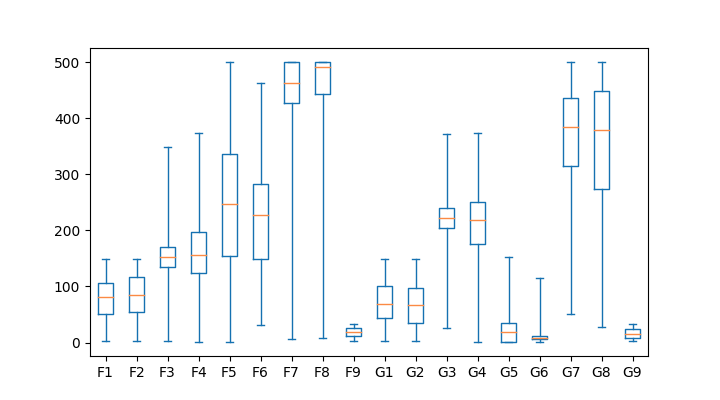

In [50]:
flux_distribution(output_data_loader)

In [70]:
def obj_value_boxplot_comparison(output_data_loader):
    model_list = [
        'model1_all_tissue', 'model1_all_tissue_m5', 'model1_all_tissue_m9', 'model1_all_tissue_lactate',
        'model1_all_tissue_lactate_m4', 'model1_all_tissue_lactate_m10',
        'model1_all_tissue_lactate_m11', 'model1_unfitted']
    ylim = [0, 0.5]  # model1

#     model_list = ['model6', 'model6_m2', 'model6_m3', 'model6_m4', 'model6_unfitted']
#     ylim = [0, 4.0]  # model6
    # model_list = ['model7', 'model7_unfitted']
    # ylim = [0, 5.0]  # model7
    # model_list = ['model5', 'model5_unfitted']
    # ylim = [0, 0.8]  # model5
    # model_list = ['model1_all_tissue', 'model1_unfitted']
    # ylim = [0, 0.5]  # model1
    # model_list = ['model3_all_tissue', 'model3_unfitted']
    # ylim = [0, 0.6]  # model3
    server_data = False

    obj_array_name = 'filtered_obj_array'
    empty_label = ''

    unfitted_obj_array = None
    if server_data:
        model_list = ['{}_server'.format(model_name) for model_name in model_list]
    unfitted_model_name = model_list[-1]
    model_objective_data_dict = {}
    for model_name in model_list:
        output_data_dict = output_data_loader[model_name]
        for tissue_name, tissue_data_dict in output_data_dict.items():
            filtered_obj_array = tissue_data_dict[obj_array_name]
            if tissue_name == '':
                if model_name == unfitted_model_name:
                    unfitted_obj_array = filtered_obj_array
                    for added_model_name, obj_array_data_dict in model_objective_data_dict.items():
                        obj_array_data_dict[unfitted_model_name] = filtered_obj_array
                else:
                    if empty_label not in model_objective_data_dict:
                        model_objective_data_dict[empty_label] = {}
                    model_objective_data_dict[empty_label][model_name] = filtered_obj_array
            else:
                if model_name not in model_objective_data_dict:
                    model_objective_data_dict[model_name] = {}
                model_objective_data_dict[model_name][tissue_name] = filtered_obj_array
    for model_label, current_obj_data_dict in model_objective_data_dict.items():
        for model_name, model_obj_data in current_obj_data_dict.items():
            if model_name == unfitted_model_name:
                continue
            else:
                stat, pvalue = scipy.stats.ranksums(unfitted_obj_array, model_obj_data)
                print("model {} {}\t\tU-stat: {}\t\tp-value: {}".format(model_label, model_name, stat, pvalue))
        if model_label == empty_label:
            figure_title = None
        else:
            figure_title = model_label
        plot_box_distribution(
            current_obj_data_dict, ylim=ylim, title=figure_title, figsize=(len(current_obj_data_dict)/1.25, 4),)
    plt.show()


model model1_all_tissue Ht		U-stat: 518.2601328906503		p-value: 0.0
model model1_all_tissue Br		U-stat: 596.4201557583606		p-value: 0.0
model model1_all_tissue SkM		U-stat: 620.400890032347		p-value: 0.0
model model1_all_tissue Kd		U-stat: 534.8780177731151		p-value: 0.0
model model1_all_tissue Lg		U-stat: 616.4567459542586		p-value: 0.0
model model1_all_tissue Pc		U-stat: 468.718580578969		p-value: 0.0
model model1_all_tissue SI		U-stat: 640.0128637062242		p-value: 0.0
model model1_all_tissue Sp		U-stat: 594.1080540186401		p-value: 0.0


<IPython.core.display.Javascript object>


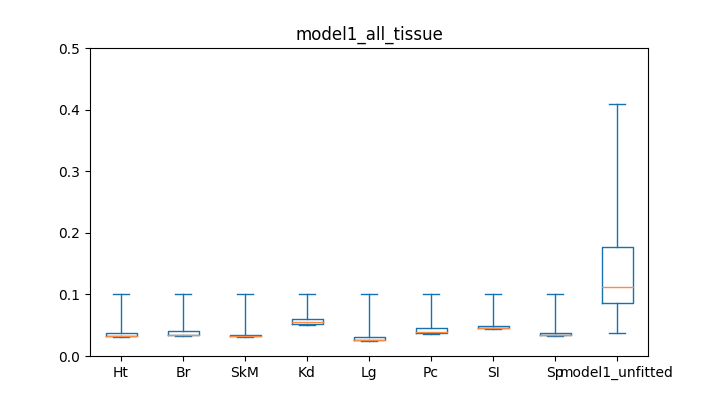

model model1_all_tissue_m5 Ht		U-stat: 560.1578650153989		p-value: 0.0
model model1_all_tissue_m5 Br		U-stat: 635.9591277193097		p-value: 0.0
model model1_all_tissue_m5 SkM		U-stat: 700.4371630432443		p-value: 0.0
model model1_all_tissue_m5 Kd		U-stat: 484.5131865918809		p-value: 0.0
model model1_all_tissue_m5 Lg		U-stat: 574.4472023109959		p-value: 0.0
model model1_all_tissue_m5 Pc		U-stat: 591.3097186267701		p-value: 0.0
model model1_all_tissue_m5 SI		U-stat: 576.0415911835482		p-value: 0.0
model model1_all_tissue_m5 Sp		U-stat: 607.4297101599142		p-value: 0.0


<IPython.core.display.Javascript object>


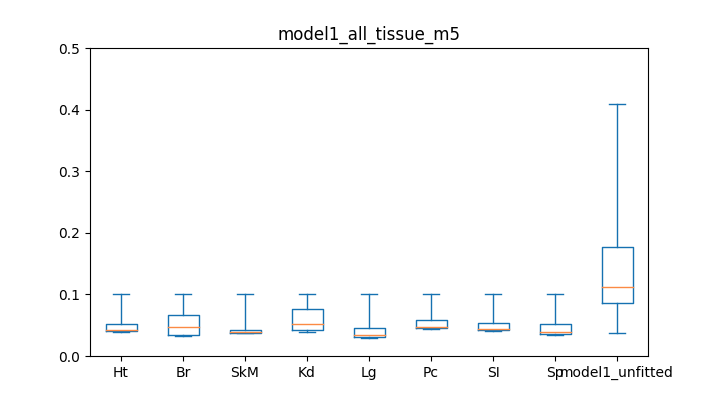

model model1_all_tissue_m9 Ht		U-stat: 303.5149438678096		p-value: 0.0
model model1_all_tissue_m9 Br		U-stat: 370.0000304346326		p-value: 0.0
model model1_all_tissue_m9 SkM		U-stat: 348.4466093158436		p-value: 0.0
model model1_all_tissue_m9 Kd		U-stat: 75.58895754601993		p-value: 0.0
model model1_all_tissue_m9 Lg		U-stat: 467.1139560988601		p-value: 0.0
model model1_all_tissue_m9 Pc		U-stat: 388.5761493781956		p-value: 0.0
model model1_all_tissue_m9 SI		U-stat: 214.83224295072202		p-value: 0.0
model model1_all_tissue_m9 Sp		U-stat: 377.36023962637984		p-value: 0.0


<IPython.core.display.Javascript object>


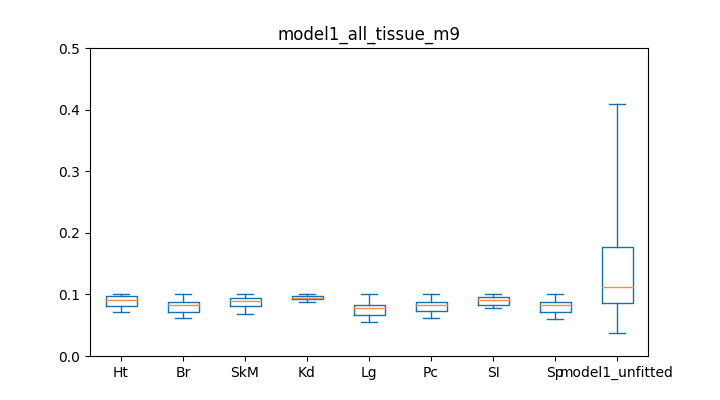

model model1_all_tissue_lactate Ht		U-stat: 749.1581894964256		p-value: 0.0
model model1_all_tissue_lactate Br		U-stat: 585.04415802275		p-value: 0.0
model model1_all_tissue_lactate SkM		U-stat: 644.4607086224939		p-value: 0.0
model model1_all_tissue_lactate Kd		U-stat: 642.7049586721171		p-value: 0.0
model model1_all_tissue_lactate Lg		U-stat: 712.5048985947681		p-value: 0.0
model model1_all_tissue_lactate Pc		U-stat: 630.4876210624903		p-value: 0.0
model model1_all_tissue_lactate SI		U-stat: 697.1909443741213		p-value: 0.0
model model1_all_tissue_lactate Sp		U-stat: 693.6753361580625		p-value: 0.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


<IPython.core.display.Javascript object>


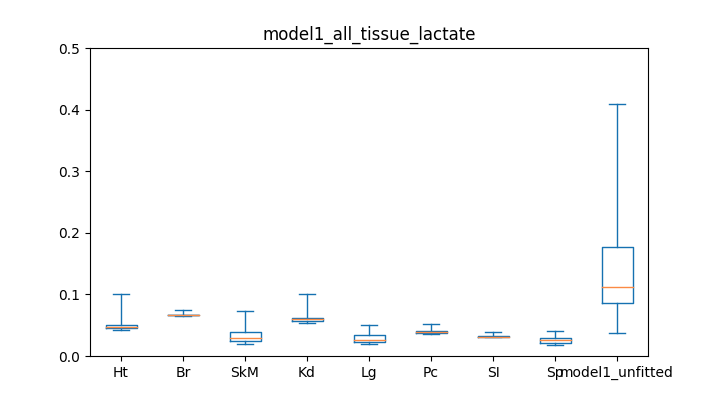

model model1_all_tissue_lactate_m4 Ht		U-stat: 660.917886148826		p-value: 0.0
model model1_all_tissue_lactate_m4 Br		U-stat: 651.3508852709496		p-value: 0.0
model model1_all_tissue_lactate_m4 SkM		U-stat: 625.7721371722763		p-value: 0.0
model model1_all_tissue_lactate_m4 Kd		U-stat: 658.344818752556		p-value: 0.0
model model1_all_tissue_lactate_m4 Lg		U-stat: 689.7215101837126		p-value: 0.0
model model1_all_tissue_lactate_m4 Pc		U-stat: 599.6130770885666		p-value: 0.0
model model1_all_tissue_lactate_m4 SI		U-stat: 704.0903172172808		p-value: 0.0
model model1_all_tissue_lactate_m4 Sp		U-stat: 653.2825629770399		p-value: 0.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


<IPython.core.display.Javascript object>


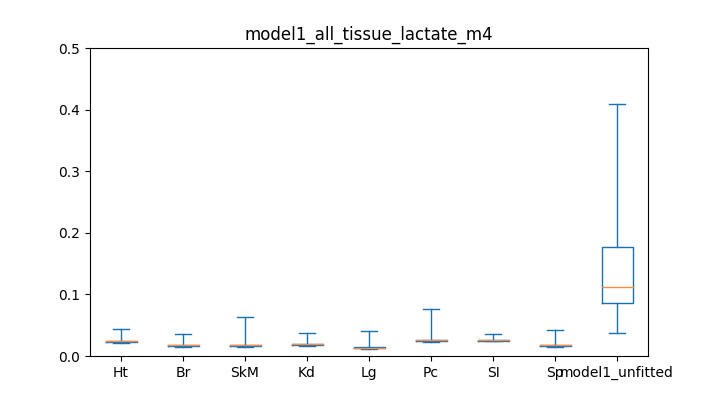

model model1_all_tissue_lactate_m10 Ht		U-stat: 672.3798478553421		p-value: 0.0
model model1_all_tissue_lactate_m10 Br		U-stat: 672.1361166320002		p-value: 0.0
model model1_all_tissue_lactate_m10 SkM		U-stat: 669.0075175805058		p-value: 0.0
model model1_all_tissue_lactate_m10 Kd		U-stat: 668.30874444134		p-value: 0.0
model model1_all_tissue_lactate_m10 Lg		U-stat: 663.4377303965509		p-value: 0.0
model model1_all_tissue_lactate_m10 Pc		U-stat: 525.9539771864704		p-value: 0.0
model model1_all_tissue_lactate_m10 SI		U-stat: 672.680932649618		p-value: 0.0
model model1_all_tissue_lactate_m10 Sp		U-stat: 662.8100196092067		p-value: 0.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


<IPython.core.display.Javascript object>


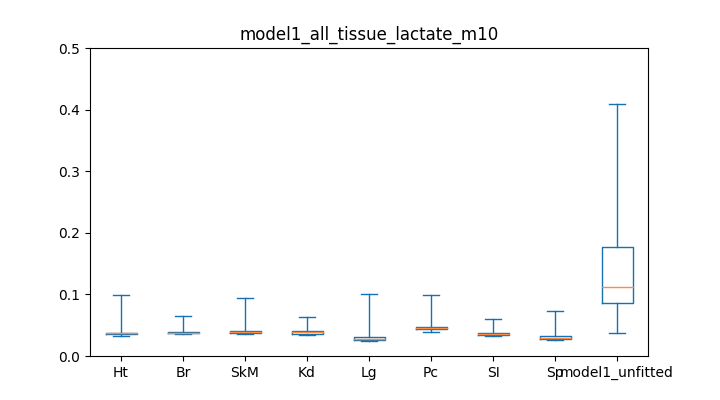

model model1_all_tissue_lactate_m11 Ht		U-stat: 666.2882788772993		p-value: 0.0
model model1_all_tissue_lactate_m11 Br		U-stat: 646.4432617436262		p-value: 0.0
model model1_all_tissue_lactate_m11 SkM		U-stat: 685.0066883245119		p-value: 0.0
model model1_all_tissue_lactate_m11 Kd		U-stat: 633.6014136631275		p-value: 0.0
model model1_all_tissue_lactate_m11 Lg		U-stat: 530.5252723070305		p-value: 0.0
model model1_all_tissue_lactate_m11 Pc		U-stat: 517.5863911866652		p-value: 0.0
model model1_all_tissue_lactate_m11 SI		U-stat: 638.0854193025376		p-value: 0.0
model model1_all_tissue_lactate_m11 Sp		U-stat: 558.1172316137576		p-value: 0.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


<IPython.core.display.Javascript object>


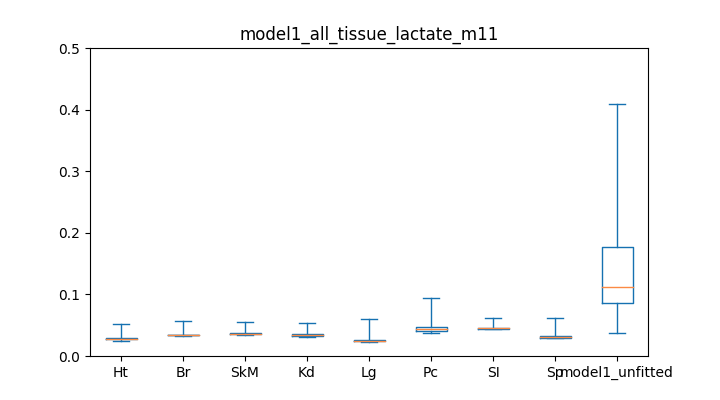

In [71]:
obj_value_boxplot_comparison(output_data_loader)

In [12]:
def glucose_contribution_plotting(output_data_loader):
    # model_list = ['model6', 'model6_m2', 'model6_m3', 'model6_m4']
    # abbr_name_list = ['m1', 'm2', 'm3', 'm4']
    model_list = [
        'model1_all_tissue', 'model1_all_tissue_m5', 'model1_all_tissue_m9',
        'model1_all_tissue_lactate', 'model1_all_tissue_lactate_m4', 'model1_all_tissue_lactate_m10',
        'model1_all_tissue_lactate_m11']
    abbr_name_list = [
        'glc_m1', 'glc_m5', 'glc_m9', 'lac_m3', 'lac_m4', 'lac_m10', 'lac_m11']
    # model_list = ['model5', 'model5_comb2']
    # abbr_name_list = ['comb1', 'comb2']

    model12_data_dict_name = 'well_fit_glucose_contri_dict'
    model345_data_dict_name = 'well_fit_contri_list_dict'
    sink_name = 'sink'
    sink1_name = 'sink1'
    sink2_name = 'sink2'

    glucose_contribution_data_dict = {}
    tissue_list = None
    for model_full_name, abbr_name in zip(model_list, abbr_name_list):
        output_data_dict = output_data_loader[model_full_name]
        if tissue_list is None:
            tissue_list = list(output_data_dict.keys())
        for tissue_name in tissue_list:
            if tissue_name not in glucose_contribution_data_dict:
                glucose_contribution_data_dict[tissue_name] = {}
            current_contribution_data_dict = glucose_contribution_data_dict[tissue_name]

            tissue_data_dict = output_data_dict[tissue_name]
            if model12_data_dict_name in tissue_data_dict:
                current_contribution_data_dict[abbr_name] = tissue_data_dict[model12_data_dict_name][sink_name]
            elif model345_data_dict_name in tissue_data_dict:
                model_sink1_name = "{}_{}".format(abbr_name, sink1_name)
                model_sink2_name = "{}_{}".format(abbr_name, sink2_name)
                model_sink_name = "{}_{}".format(abbr_name, sink_name)
                current_contribution_data_dict[model_sink1_name] = tissue_data_dict[model345_data_dict_name][sink1_name]
                current_contribution_data_dict[model_sink2_name] = tissue_data_dict[model345_data_dict_name][sink2_name]
                current_contribution_data_dict[model_sink_name] = tissue_data_dict[model345_data_dict_name][sink_name]
            else:
                raise ValueError()

    for tissue_name in tissue_list:
        if tissue_name == '':
            title = None
        else:
            title = tissue_name
        plot_violin_distribution(
            glucose_contribution_data_dict[tissue_name],
            color_dict=color_set.blue,
            median_color_dict=color_set.orange,
            title=title,
            cutoff=0.5, ylim=[-0.1, 1.1], figsize=(6, 4))
    plt.show()

<IPython.core.display.Javascript object>


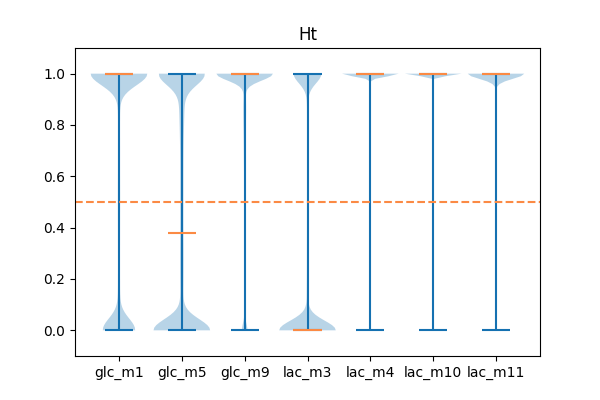

<IPython.core.display.Javascript object>


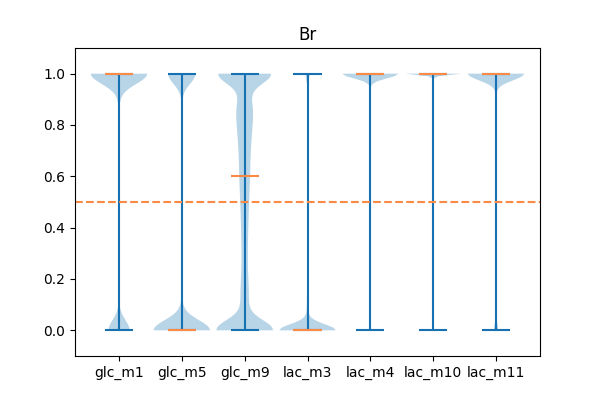

<IPython.core.display.Javascript object>


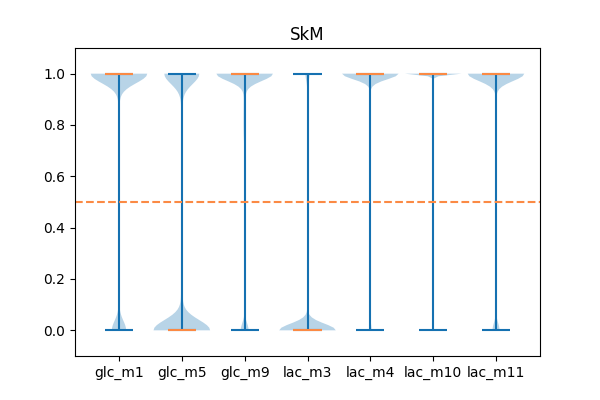

<IPython.core.display.Javascript object>


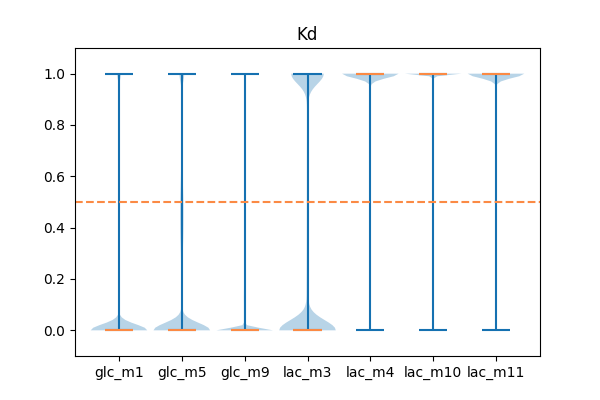

<IPython.core.display.Javascript object>


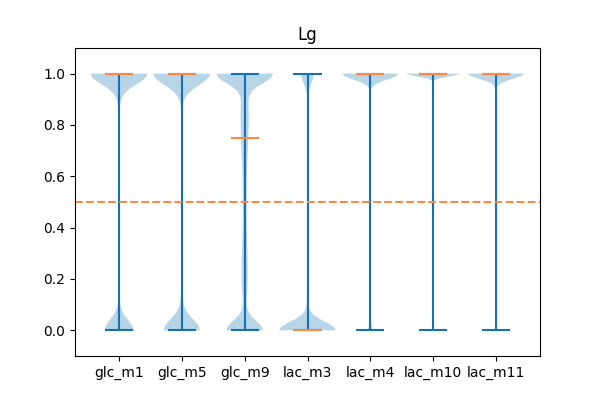

<IPython.core.display.Javascript object>


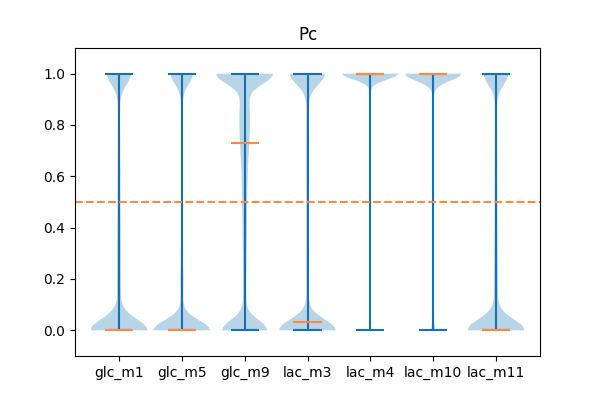

<IPython.core.display.Javascript object>


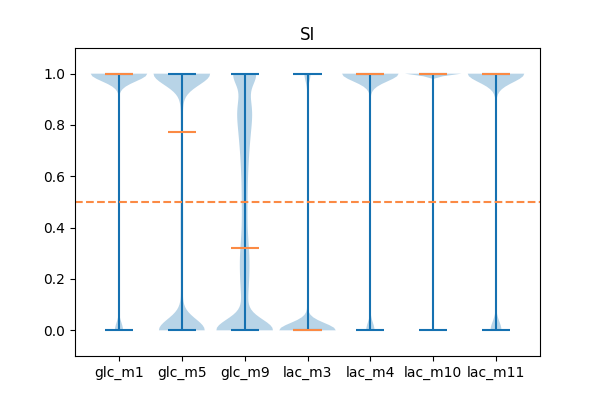

<IPython.core.display.Javascript object>


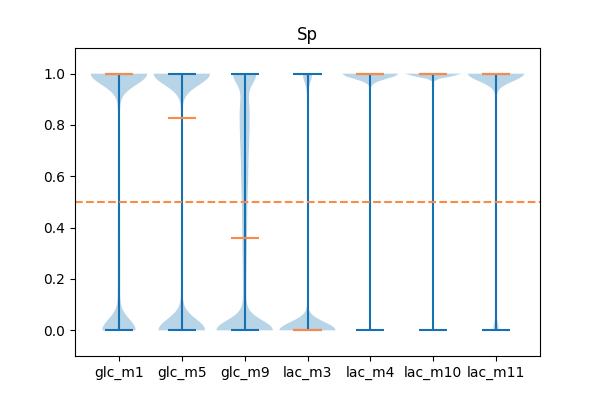

In [13]:
glucose_contribution_plotting(output_data_loader)

In [72]:
def all_tissue_ternary_plotting(output_data_loader):
    sqrt_3 = np.sqrt(3)

    def standard_2dnormal(x, y, _sigma):
        return np.exp(-0.5 / _sigma ** 2 * (x ** 2 + y ** 2)) / (2 * np.pi * _sigma ** 2)

    # Each row is the cartesian cor.
    def tri_to_car(input_data_matrix):
        y_value = input_data_matrix[:, 1] * sqrt_3 / 2
        x_value = input_data_matrix[:, 0] + y_value / sqrt_3
        return np.vstack([x_value, y_value]).T

    def car_to_tri(input_data_matrix):
        y_value = input_data_matrix[:, 1]
        x2_value = y_value / (sqrt_3 / 2)
        x1_value = input_data_matrix[:, 0] - y_value / sqrt_3
        return np.vstack([x1_value, x2_value]).T

    def gaussian_kernel_generator(_bin_num, _sigma):
        x = np.linspace(0, 1, _bin_num) - 0.5
        y = np.linspace(0, 1, _bin_num) - 0.5
        X, Y = np.meshgrid(x, y)
        gaussian_kernel = standard_2dnormal(X, Y, _sigma)
        return np.rot90(gaussian_kernel)

    def bin_car_data_points(_car_data_matrix, _bin_num):
        histogram, _, _ = np.histogram2d(
            _car_data_matrix[:, 0], _car_data_matrix[:, 1], bins=np.linspace(0, 1, _bin_num + 1))
        return histogram

    def complete_tri_set_interpolation(_location_list, _value_list, _scale):
        result_tri_array = np.array(list(simplex_iterator(_scale))) / _scale
        result_car_array = tri_to_car(result_tri_array)
        result_value_array = scipy.interpolate.griddata(
            np.array(_location_list), np.array(_value_list), result_car_array, method='cubic')
        target_dict = {}
        for (i, j, k), result_value in zip(simplex_iterator(bin_num), result_value_array):
            target_dict[(i, j)] = result_value
        return target_dict

    # model_name = "model3_all_tissue"
    model_name = "model3"
    # model_name = "model7"
    test_mode = False
    if test_mode:
        bin_num = 2 ** 5
        vmax = 400
    else:
        bin_num = 2 ** 8
        # vmax = 500000
        vmax = None

    sigma = 0.15
    mean = True

    model_figure_location_list = [
        (0, 0, 1), (0, 1, 1), (0, 2, 1), (0, 3, 1),
        (1, 0, 1), (1, 1, 1), (1, 2, 1), (1, 3, 1)]

    contribution_dict_name = 'well_fit_contri_list_dict'
    sink_name = 'sink'

    output_data_dict = output_data_loader[model_name]
    contribution_matrix_dict = {}
    for tissue_name, current_data_dict in output_data_dict.items():
        if tissue_name == '':
            tissue_name = model_name
        contribution_matrix_dict[tissue_name] = current_data_dict[contribution_dict_name][sink_name]
    if 'all_tissue' in model_name:
        # contribution_matrix_dict.update(output_data_dict['contribution_matrix_dict'])
        complete_fig = plt.figure(figsize=(15, 8))
        title_fig = plt.figure()
        tick_format = "%.1f"
        offset = 0.02
        colorbar = False
    else:
        # contribution_matrix_dict[model_name] = output_data_dict['contribution_matrix']
        # complete_fig = plt.figure(figsize=(9, 8))
        vmax = None
        tick_format = ""
        offset = 0.01
        colorbar = True

    # output_direct = "{}/{}".format(total_output_direct, model_name)
    # save_path = "{}/glucose_contribution_heatmap.png".format(output_direct)

    location_dict = {
        tissue_name: location_tuple for tissue_name, location_tuple
        in zip(contribution_matrix_dict.keys(), model_figure_location_list)}
    location_array = np.array(list(it.product(np.linspace(0, 1, bin_num), repeat=2)))
    tick_labels = list(np.linspace(0, bin_num, 6) / bin_num)
    gaussian_kernel_matrix = gaussian_kernel_generator(bin_num, sigma)

    max_x_index = 0
    max_y_index = 0
    for x_index, y_index, _ in location_dict.values():
        max_x_index = max(x_index, max_x_index)
        max_y_index = max(y_index, max_y_index)
    grid = plt.GridSpec(max_x_index + 1, max_y_index + 1, hspace=0.3, wspace=0.1)
    for tissue_name, contribution_matrix in contribution_matrix_dict.items():
        if 'all_tissue' in model_name:
            x_start, y_start, y_len = location_dict[tissue_name]
            title_ax = title_fig.add_subplot(grid[x_start, y_start:y_start + y_len])
            ax = complete_fig.add_subplot(grid[x_start, y_start:y_start + y_len])
            fig, tax = ternary.figure(ax=ax, scale=bin_num)
            title_ax.text(0.5, 0.5, tissue_name)
        else:
            fig, tax = ternary.figure(scale=bin_num)

        car_data_matrix = tri_to_car(contribution_matrix)
        data_bin_matrix = bin_car_data_points(car_data_matrix, bin_num)
        car_blurred_matrix = scipy.signal.convolve2d(data_bin_matrix, gaussian_kernel_matrix, mode='same')
        value_array = car_blurred_matrix.reshape([-1])
        complete_density_dict = complete_tri_set_interpolation(location_array, value_array, bin_num)

        tax.heatmap(complete_density_dict, cmap='Blues', style="h", vmin=0, vmax=vmax, colorbar=colorbar)
        tax.boundary(linewidth=1.0)
        if 'all_tissue' in model_name:
            tax.get_axes().axis('off')
        tax.ticks(axis='lbr', ticks=tick_labels, linewidth=1, offset=offset, tick_formats=tick_format)
        tax.clear_matplotlib_ticks()
        plt.tight_layout()
        if mean:
            mean_value = contribution_matrix.mean(axis=0).reshape([1, -1]) * bin_num
            tax.scatter(mean_value, marker='o', color=color_set.orange, zorder=100, s=20)

    plt.show()

<IPython.core.display.Javascript object>


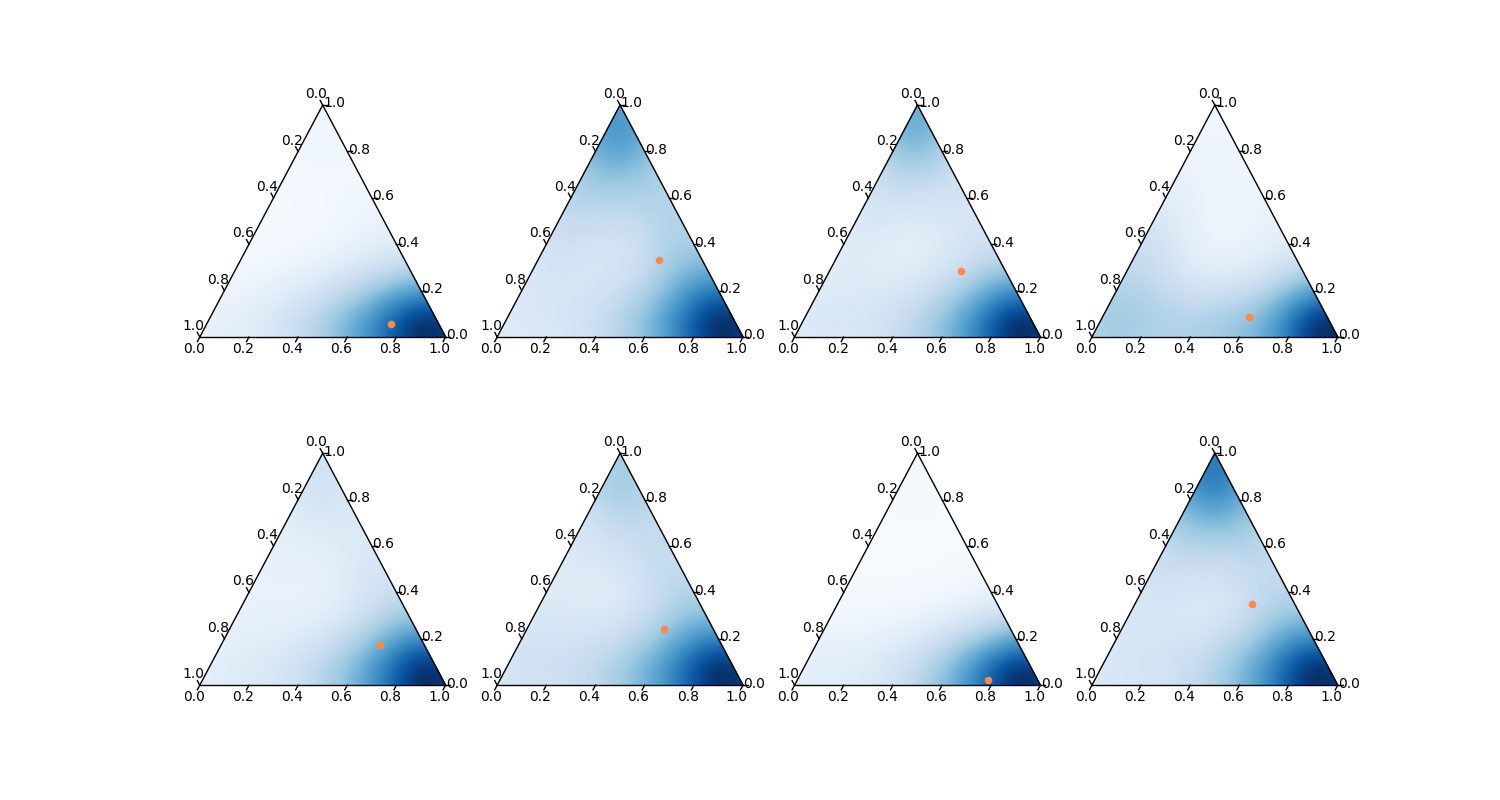

<IPython.core.display.Javascript object>


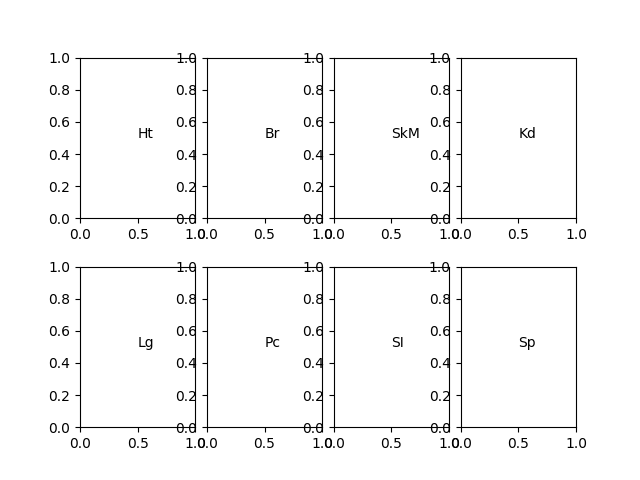

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [48]:
all_tissue_ternary_plotting(output_data_loader)

<IPython.core.display.Javascript object>


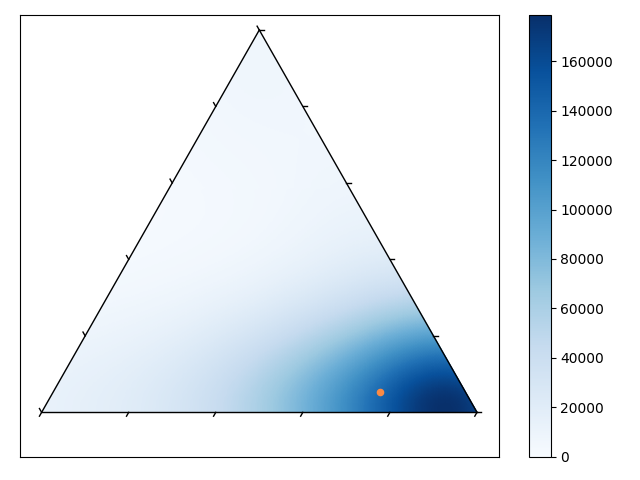

In [73]:
all_tissue_ternary_plotting(output_data_loader)

In [34]:
def plot_mid_bar_subplots(
        figure_data_dict, group_num, location_dict, color_dict=None,
        threshold_ratio=None, error_bar_complete_dict=None, figure_title=None, save_path=None):
    max_x_index = 0
    max_y_index = 0
    for x_index, y_index, _ in location_dict.values():
        max_x_index = max(x_index, max_x_index)
        max_y_index = max(y_index, max_y_index)
    edge = 0.2
    bar_total_width = 0.7
    bar_unit_width = bar_total_width / group_num
    if max_x_index + 1 == 2:
        y_size = 4.7
    else:
        y_size = 6.6
    fig = plt.figure(figsize=(10, y_size))
    title_fig = plt.figure()
    grid = plt.GridSpec(max_x_index + 1, max_y_index + 1, hspace=0.1, wspace=0.1)
    if threshold_ratio is None:
        threshold_ratio = 0
    max_y_value = 1 - threshold_ratio
    for data_title, data_dict in figure_data_dict.items():
        current_error_bar_dict = error_bar_complete_dict[data_title]
        array_len = 0
        x_start, y_start, y_len = location_dict[data_title]
        ax = fig.add_subplot(grid[x_start, y_start:y_start + y_len])
        title_ax = title_fig.add_subplot(grid[x_start, y_start:y_start + y_len])
        title_ax.text(0.5, 0.5 * max_y_value, data_title)
        for data_name, np_array in data_dict.items():
            if array_len == 0:
                array_len = len(np_array)
            elif len(np_array) != array_len:
                raise ValueError("Length of array not equal: {}".format(data_name))
        x_mid_loc = np.arange(array_len) + 0.5
        x_left_loc = x_mid_loc - bar_total_width / 2
        for index, (data_name, mid_array) in enumerate(data_dict.items()):
            if color_dict is not None:
                current_color = color_dict[data_name]
            else:
                current_color = None
            if current_error_bar_dict is not None and data_name in current_error_bar_dict:
                error_bar_vector = current_error_bar_dict[data_name]
                error_bar_param = {
                    'ecolor': current_color,
                    'capsize': 3,
                    'elinewidth': 1.5
                }
            else:
                error_bar_vector = None
                error_bar_param = {}
            x_loc = x_left_loc + index * bar_unit_width + bar_unit_width / 2
            ax.bar(
                x_loc, mid_array, width=bar_unit_width, color=current_color, alpha=color_set.alpha_for_bar_plot,
                label=data_name, yerr=error_bar_vector, error_kw=error_bar_param)
        # ax.set_xlabel(data_dict.keys())
        ax.set_ylim([0, max_y_value])
        title_ax.set_ylim([0, max_y_value])
        ax.set_xlim([-edge, array_len + edge])
        ax.set_xticks(x_mid_loc)
        ax.set_xticklabels([])
        ax.set_yticks(np.linspace(0, max_y_value, 5))
        title_ax.set_yticks(np.linspace(0, max_y_value, 5))
        ax.set_yticklabels([])
        title_ax.set_yticklabels(["{:.2f}".format(num) for num in np.linspace(0, max_y_value, 5)])
        # ax.set_title(data_title)
    if figure_title:
        title_fig.suptitle(figure_title)
    if save_path:
        fig.savefig(save_path, dpi=fig.dpi)

In [35]:
def fitting_result_display(
        raw_output_data_loader, figure_location_list, data_loader_func, model_name, model_construction_func,
        obj_tolerance, **other_parameters):
    server_data = False
    threshold_ratio = 0.8
    experimental_label = 'Experimental MID'
    predicted_label = 'Calculated MID'
    plot_color_dict = {experimental_label: color_set.blue, predicted_label: color_set.orange}

    if server_data:
        model_name = "{}_server".format(model_name)
    raw_input_data_dict = raw_output_data_loader[model_name]
    model_mid_data_dict = data_loader_func(**other_parameters)

    if 'all_tissue' not in model_name:
        model_mid_data_dict = {'': model_mid_data_dict}
    for tissue_name, current_mid_data_dict in model_mid_data_dict.items():
        _, mid_constraint_list = model_construction_func(current_mid_data_dict)
        target_vector_dict = {}
        mid_size_dict = {}
        for mid_constraint_dict in mid_constraint_list:
            target_vector = mid_constraint_dict[constant_set.target_label]
            name = "_".join([name for name in mid_constraint_dict.keys() if name != 'target'])
            target_vector_dict[name] = target_vector
            mid_size_dict[name] = len(target_vector)

        current_data_dict = raw_input_data_dict[tissue_name]
        result_list = current_data_dict['result_list']
        processed_result_list = current_data_dict['processed_result_list']
        predicted_mid_collection_dict = {}
        for result_object, processed_dict in zip(result_list, processed_result_list):
            valid = processed_dict['valid']
            obj_diff = processed_dict['obj_diff']
            if valid and obj_diff < obj_tolerance:
                result_dict = result_object.result_dict
                predicted_mid_dict = new_model_main.evaluation_for_one_flux(
                    result_dict, {}, mid_constraint_list, mid_size_dict)
                for mid_name, mid_vector in predicted_mid_dict.items():
                    if mid_name not in predicted_mid_collection_dict:
                        predicted_mid_collection_dict[mid_name] = []
                    predicted_mid_collection_dict[mid_name].append(mid_vector)
        data_dict_for_figure = {}
        error_bar_dict_for_figure = {}
        figure_location_dict = {}
        current_threshold_ratio = None
        shrink_axis_list = []
        for index, (mid_name, mid_vector_list) in enumerate(predicted_mid_collection_dict.items()):
            predicted_mid_mean = np.mean(mid_vector_list, axis=0)
            predicted_mid_std = np.std(mid_vector_list, axis=0)
            target_mid_vector = target_vector_dict[mid_name]
            if predicted_mid_mean[0] > threshold_ratio and target_mid_vector[0] > threshold_ratio:
                shrink_axis_list.append(True)
            else:
                shrink_axis_list.append(False)
            data_dict_for_figure[mid_name] = {experimental_label: target_mid_vector, predicted_label: predicted_mid_mean}
            error_bar_dict_for_figure[mid_name] = {predicted_label: predicted_mid_std}
            figure_location_dict[mid_name] = figure_location_list[index]
        if np.all(shrink_axis_list):
            current_threshold_ratio = threshold_ratio
            for mid_name in data_dict_for_figure.keys():
                target_mid_vector = data_dict_for_figure[mid_name][experimental_label]
                data_dict_for_figure[mid_name][experimental_label] = target_mid_vector[1:]
                predicted_mid_mean = data_dict_for_figure[mid_name][predicted_label]
                data_dict_for_figure[mid_name][predicted_label] = predicted_mid_mean[1:]
                predicted_mid_std = error_bar_dict_for_figure[mid_name][predicted_label]
                error_bar_dict_for_figure[mid_name][predicted_label] = predicted_mid_std[1:]
        if tissue_name == '':
            title = model_name
        else:
            title = tissue_name
        plot_mid_bar_subplots(
            data_dict_for_figure, len(plot_color_dict), figure_location_dict, color_dict=plot_color_dict,
            error_bar_complete_dict=error_bar_dict_for_figure, threshold_ratio=current_threshold_ratio,
            figure_title=title)
    plt.show()

In [36]:
def mid_prediction_bar_plotting(raw_output_data_loader):
    # model_parameter_dict = model_parameter_functions.model1_parameters()
    model_parameter_dict = model_parameter_functions.model1_all_tissue()
    model_figure_location_list = [
        (1, 0, 2), (1, 2, 1), (1, 3, 1),  # Source tissue
        (0, 0, 2), (0, 2, 1), (0, 3, 1),]  # Sink tissue
    # model_parameter_dict = model_parameter_functions.model2_parameters()
    # model_parameter_dict = model_parameter_functions.model3_parameters()
    # model_figure_location_list = [
    #     (2, 0, 2), (2, 2, 1), (2, 3, 1),  # Source tissue
    #     (1, 3, 1), (1, 2, 1),  # Plasma
    #     (0, 0, 2), (0, 2, 1), (0, 3, 1),]  # Sink tissue
    # model_parameter_dict = model_parameter_functions.model4_parameters()
    # model_parameter_dict = model_parameter_functions.model5_parameters()
    # model_figure_location_list = [
    #     (2, 0, 2), (2, 2, 1), (2, 3, 1),  # Source tissue
    #     (0, 0, 2), (0, 2, 1), (0, 3, 1),  # Sink tissue 1
    #     (1, 0, 2), (1, 2, 1), (1, 3, 1)]  # Sink tissue 2
    # model_parameter_dict = model_parameter_functions.model6_parameters()
    # model_figure_location_list = [
    #     (2, 0, 2), (2, 2, 1), (2, 3, 1),  # Source tissue
    #     (0, 0, 2), (0, 2, 1), (0, 3, 1),  # Sink tissue
    #     (1, 0, 2)]  # Plasma
    # model_parameter_dict = model_parameter_functions.model7_parameters()
    # model_figure_location_list = [
    #     (2, 0, 2), (2, 2, 1), (2, 3, 1),  # Source tissue
    #     (1, 0, 2), (1, 3, 1), (1, 2, 1),  # Plasma
    #     (0, 0, 2), (0, 2, 1), (0, 3, 1),]  # Sink tissue
    fitting_result_display(
        **model_parameter_dict,
        figure_location_list=model_figure_location_list, raw_output_data_loader=raw_output_data_loader)

<IPython.core.display.Javascript object>


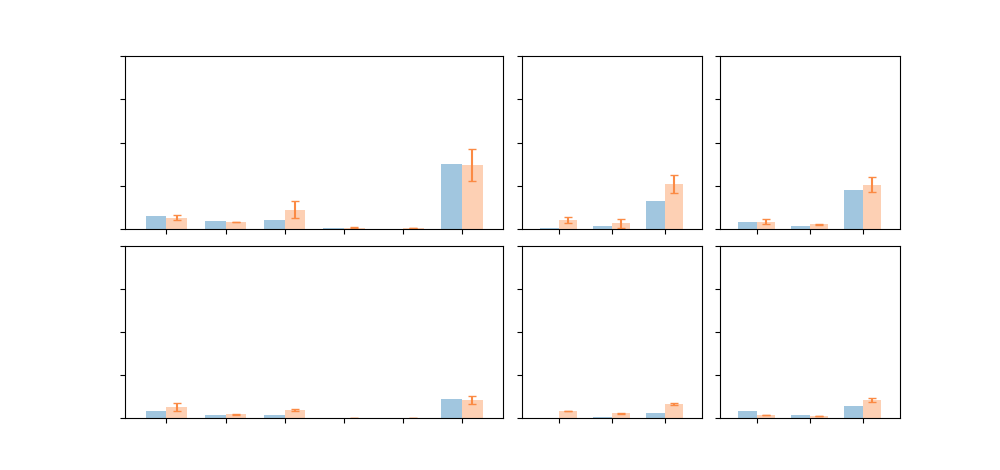

<IPython.core.display.Javascript object>


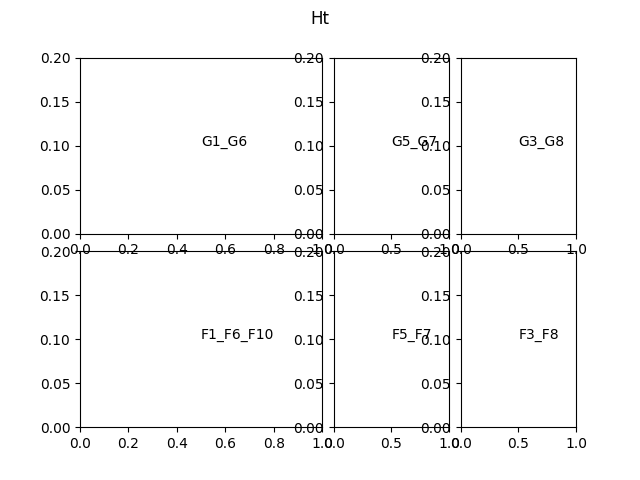

<IPython.core.display.Javascript object>


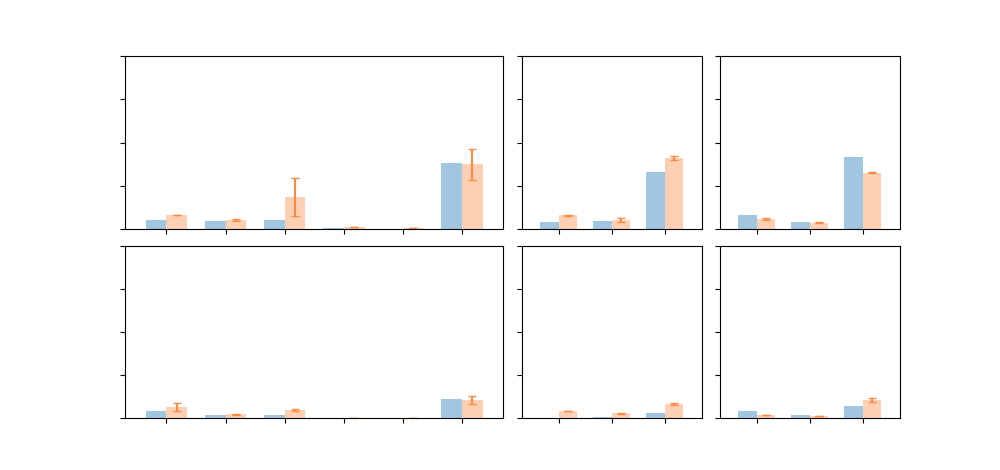

<IPython.core.display.Javascript object>


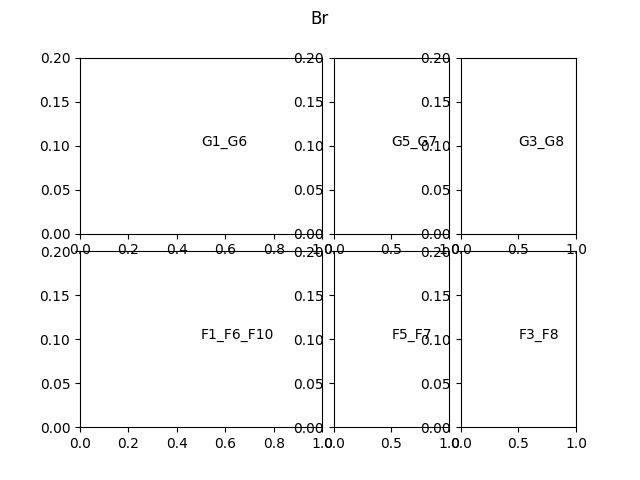

<IPython.core.display.Javascript object>


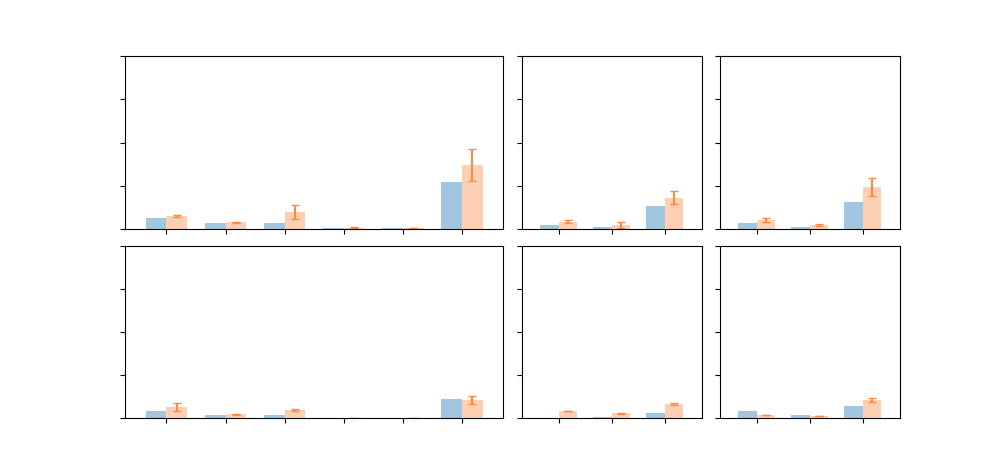

<IPython.core.display.Javascript object>


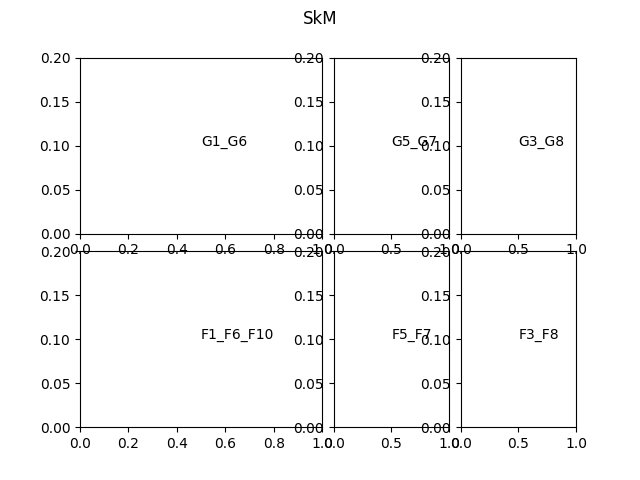

<IPython.core.display.Javascript object>


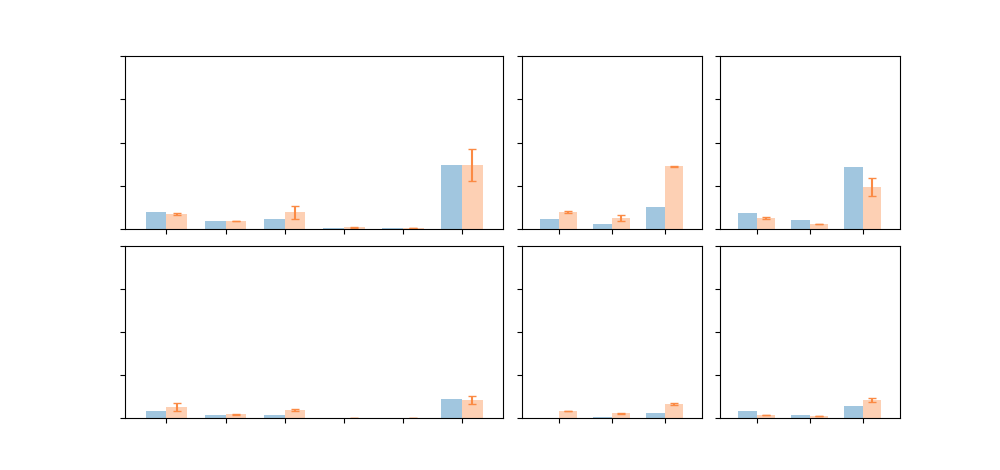

<IPython.core.display.Javascript object>


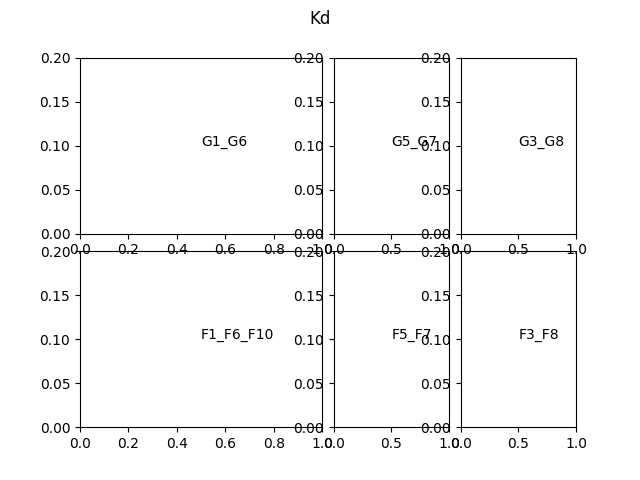

<IPython.core.display.Javascript object>


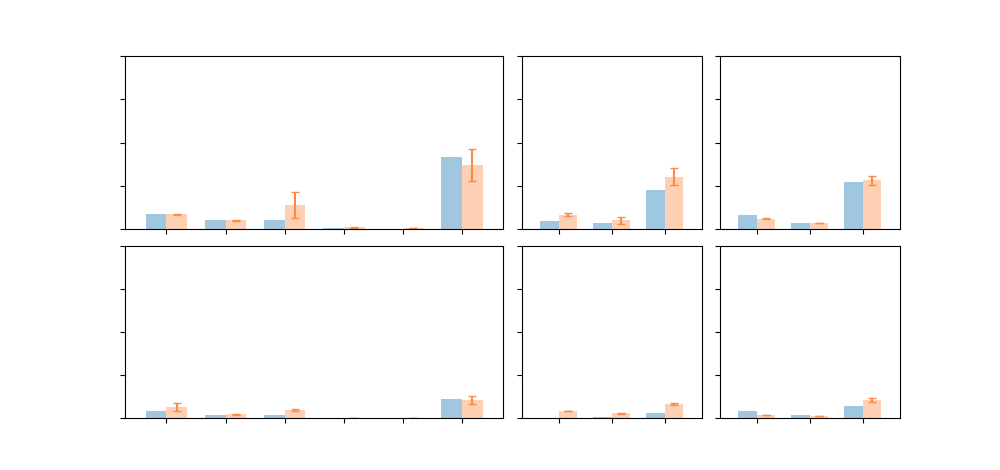

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


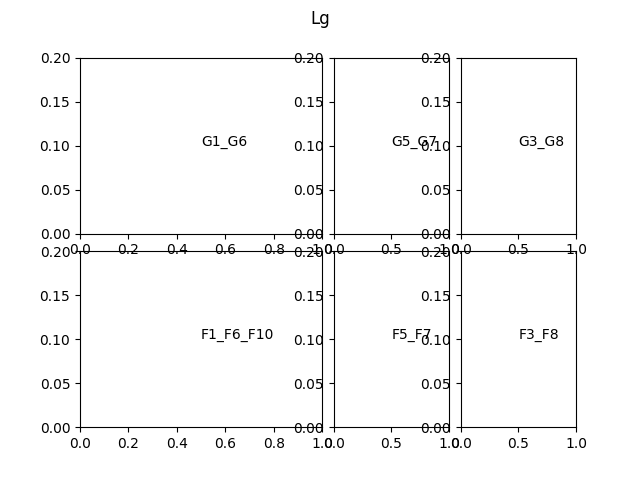

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


<IPython.core.display.Javascript object>


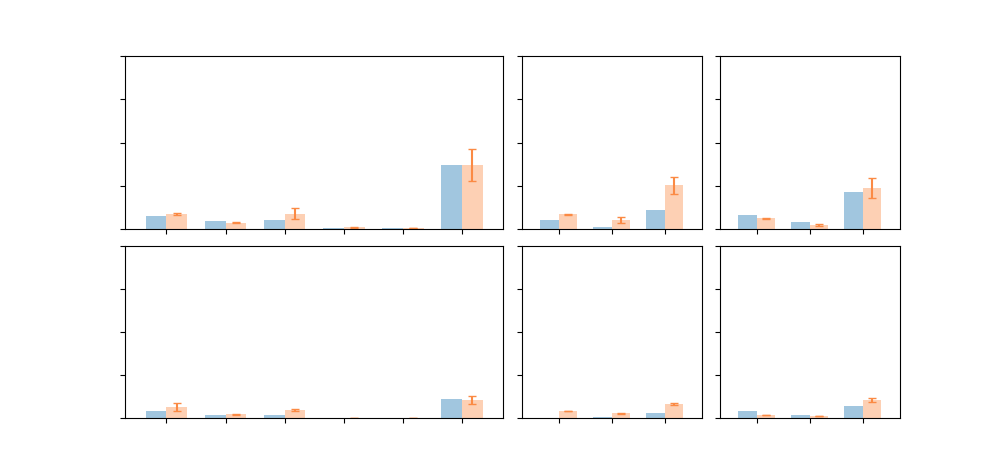

<IPython.core.display.Javascript object>


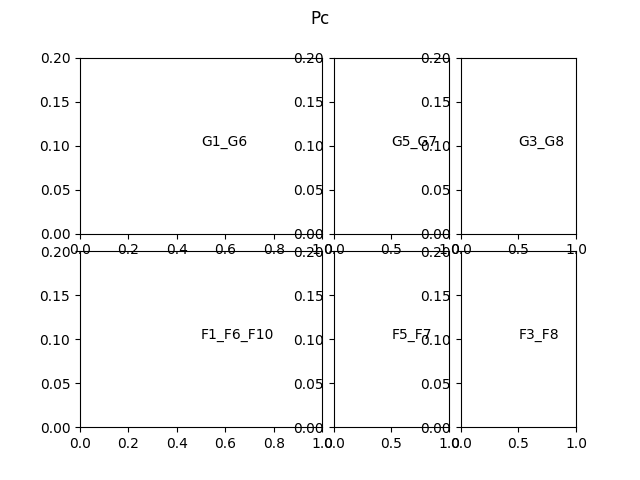

<IPython.core.display.Javascript object>


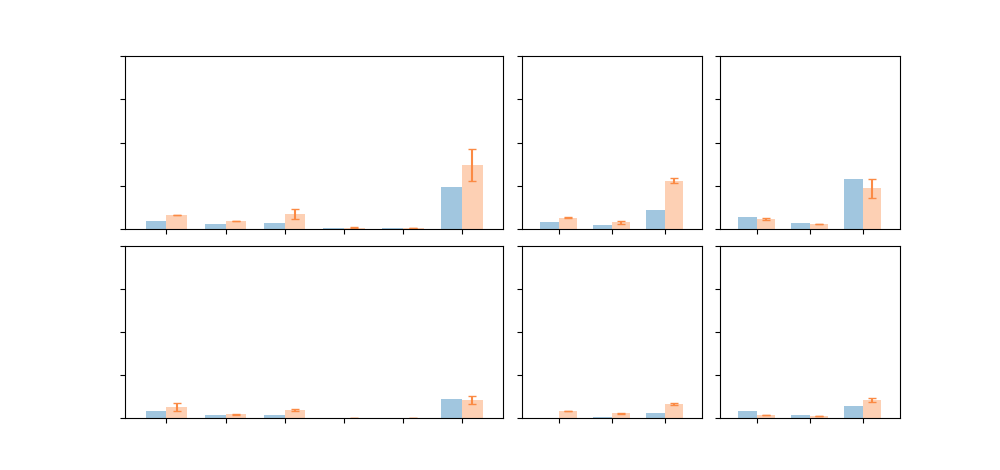

<IPython.core.display.Javascript object>


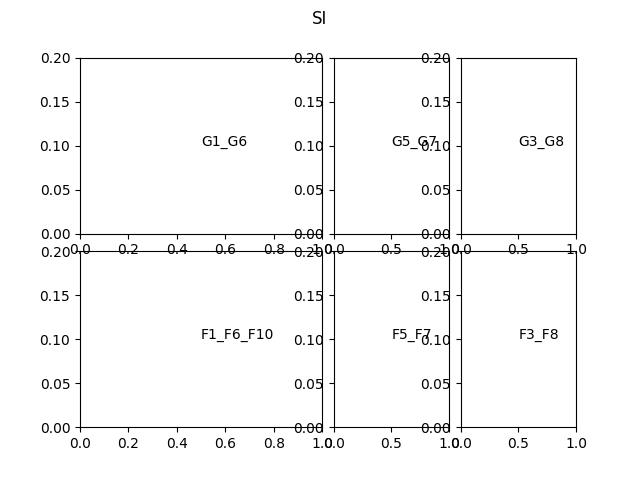

<IPython.core.display.Javascript object>


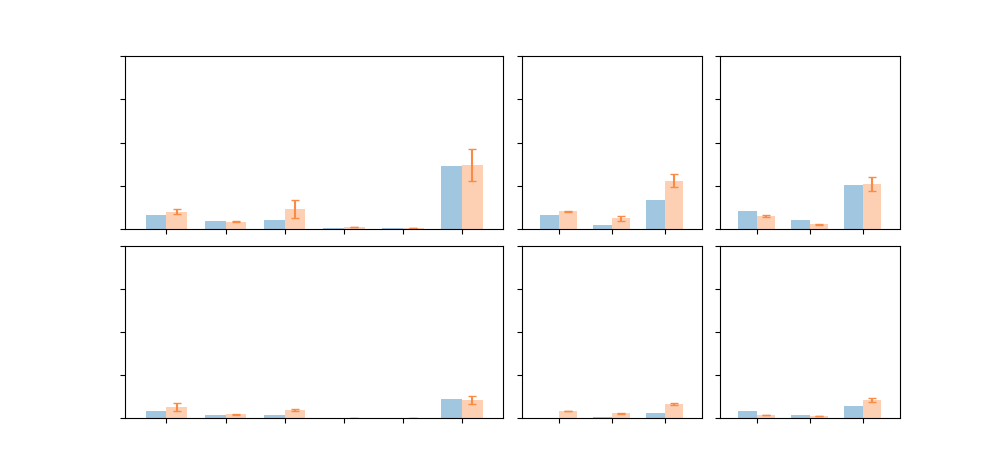

<IPython.core.display.Javascript object>


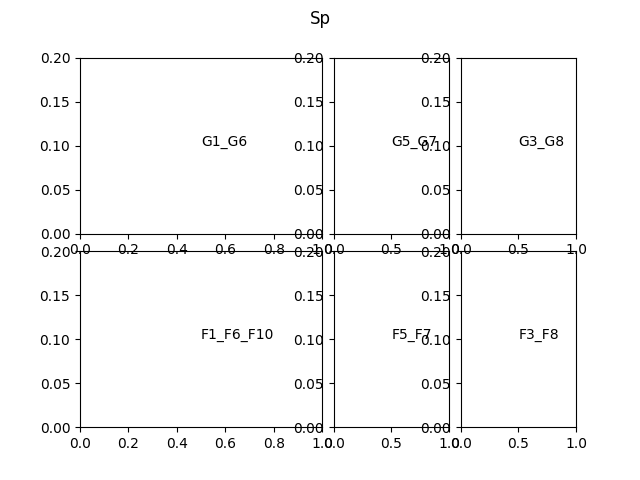

In [37]:
mid_prediction_bar_plotting(raw_output_data_loader)

In [224]:
def parameter_sensitivity_plot(output_data_loader):
    sample_type_list = ['mid', 'F10', 'Fcirc_glc', 'Fcirc_lac']

    data_dict = output_data_loader['model1_parameter_sensitivity']
    well_fit_glucose_contri_dict = data_dict['well_fit_glucose_contri_dict']
    objective_function_list_dict = data_dict['objective_function_list_dict']
    objective_function_median_dict = {}
    well_fit_median_contri_dict = {}

    for sample_type in sample_type_list:
        objective_function_median_dict[sample_type] = []
        for sample_index, obj_list in enumerate(objective_function_list_dict[sample_type]):
            objective_function_median_dict[sample_type].append(np.median(obj_list))

    for sample_type, sample_contri_list in well_fit_glucose_contri_dict.items():
        well_fit_median_contri_dict[sample_type] = []
        for sample_index, contri_list in enumerate(sample_contri_list):
            if len(contri_list) == 0:
                continue
            new_array = np.array(contri_list)
            well_fit_median_contri_dict[sample_type].append(np.median(new_array))

    for sample_type in sample_type_list:
        plot_violin_distribution(
            {sample_type: well_fit_median_contri_dict[sample_type]},
            {sample_type: color_set.purple}, ylim=[-0.05, 1.05], figsize=(1.8, 3.5))
    plot_box_distribution(objective_function_median_dict, ylim=[0, 0.4], figsize=(7, 4))
    plt.show()


<IPython.core.display.Javascript object>


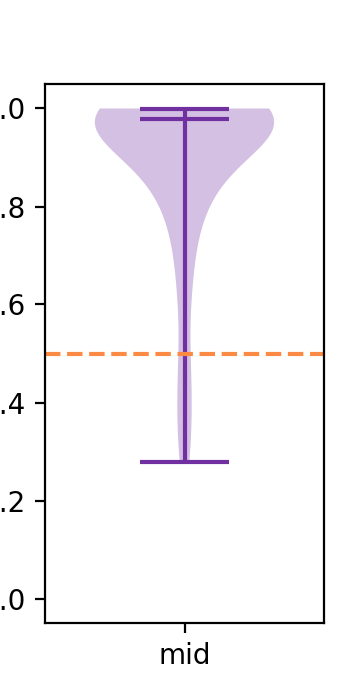

<IPython.core.display.Javascript object>


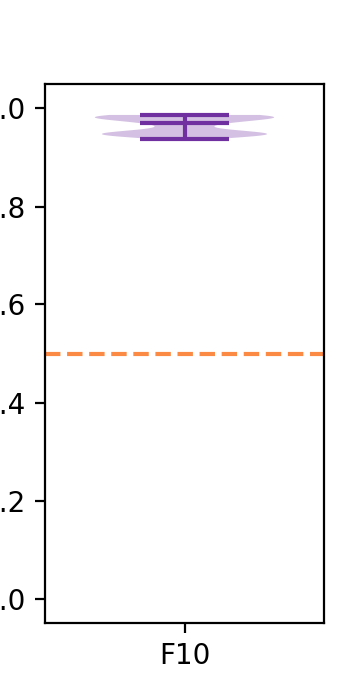

<IPython.core.display.Javascript object>


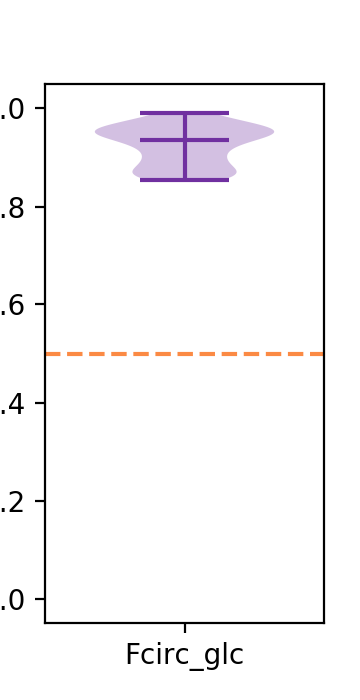

<IPython.core.display.Javascript object>


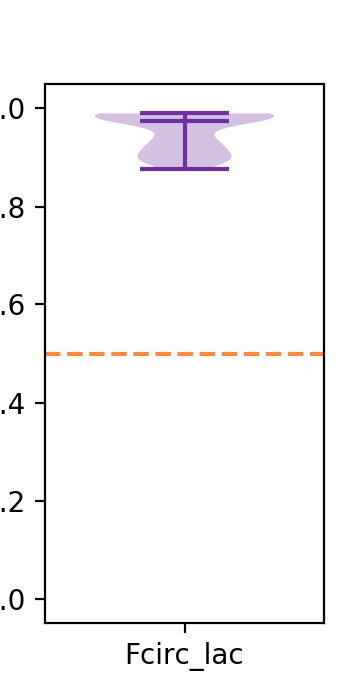

<IPython.core.display.Javascript object>


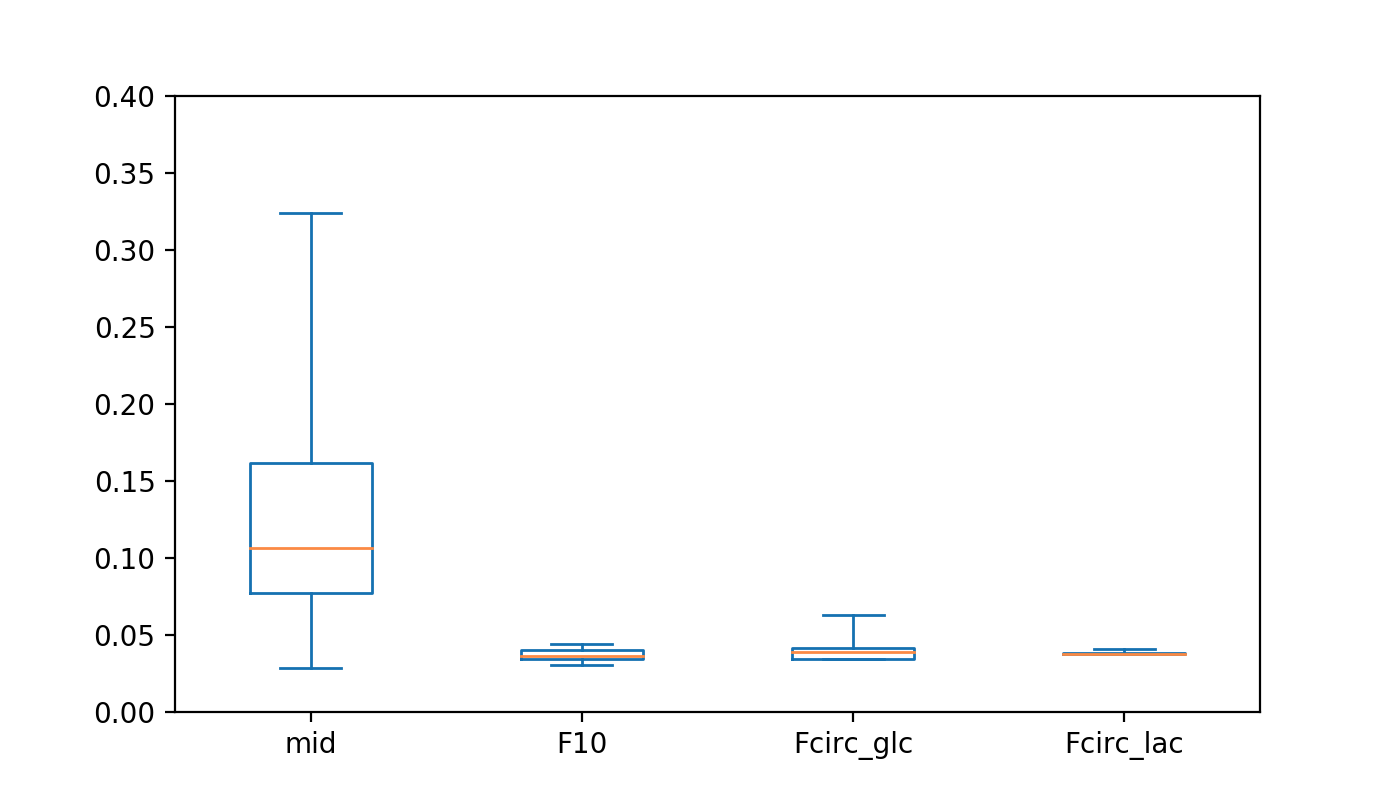

In [225]:
parameter_sensitivity_plot(output_data_loader)

In [11]:
def glucose_contribution_split_comparison(output_data_loader):
    split_model_name = "model6_split_contribution"
    together_model_name = "model6"

    split_model_data = output_data_loader[split_model_name]
    together_model_data = output_data_loader[together_model_name]

    source_glucose_contri_list, sink_glucose_contri_list = split_model_data['well_fit_glucose_contri_list']
    total_glucose_contri_list = together_model_data['well_fit_glucose_contri_list']
    glucose_contribution_data_dict = {
        'source': np.array(source_glucose_contri_list),
        'sink': np.array(sink_glucose_contri_list),
        'combined': np.array(total_glucose_contri_list)
    }

    plot_violin_distribution(
        glucose_contribution_data_dict,
        {category_name: color_set.blue for category_name in glucose_contribution_data_dict.keys()},
        cutoff=0.5, ylim=[-0.1, 1.1], figsize=(5, 4))
    plt.show()

<IPython.core.display.Javascript object>


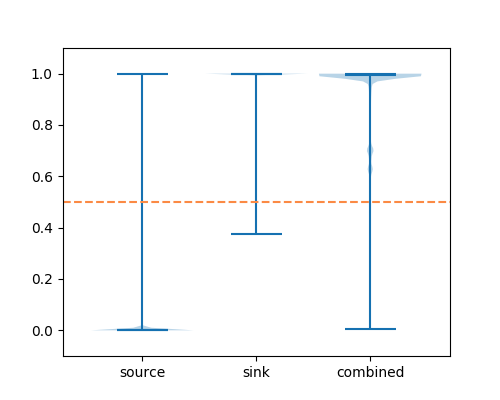

In [12]:
glucose_contribution_split_comparison(output_data_loader)